In [1]:
# Calling Packages ####
library(readr)                                                                       # Reading data set
library(caret)                                                                       # Prediction
library(doParallel)                                                                  # Providing a parallel backend
library(corrplot)                                                                    # Correlation matrix format
library(C50)                                                                         # C5.0 algorythm
library(inum)                                                                        # representation of vectors and intervals
library(plyr)                                                                        # Breaking big problems down into managable pieces and bringing back together
library(ggplot2)                                                                     # Visualization
library(plotly)                                                                      # Visualization
library(cowplot)                                                            # Plotting

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'doParallel' was built under R version 3.6.1"Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
corrplot 0.84 loaded

Attaching package: 'plotly'

The following objects are masked from 'package:plyr':

    arrange, mutate, rename, summarise

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Warning message:
"package 'cowplot' was built under R version 3.6.1"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  the

## Sentiment Analysis towards Iphone 

In [4]:
# Reading Small Matrix (Train data) for iphone
RawData_Iphone <- read.csv("C:/Users/spxt6/OneDrive/Dokumente/R_projects/Test.Proj/AWS/iphone_smallmatrix_labeled_8d.csv", 
                           TRUE, 
                           sep =","
                          )
Iphone_Train <- RawData_Iphone

In [58]:
head(Iphone_Train)

iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,iphonesentiment
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [5]:
# Reading Large Matrix (Validation data) ####
RawData_LargeMatrix <- read.csv("C:/Users/spxt6/OneDrive/Dokumente/R_projects/Test.Proj/AWS/LargeMatrix.csv", 
                                TRUE, 
                                sep =","
                               )
LargeMatrix <- RawData_LargeMatrix

In [59]:
head(LargeMatrix)

id,iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,...,samsungperunc,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc
0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


### Feature Selection 

In [7]:
# Setting Iphone_Train data as data frame
Iphone_Train.df <- as.data.frame(Iphone_Train)

In [8]:
# Finding Near Zero Variances
nzv <- nearZeroVar(Iphone_Train.df , saveMetrics = FALSE)   

In [9]:
# Creating a new data set without near zero variance
Iphone_No_NZV <- Iphone_Train.df[ , -nzv ]

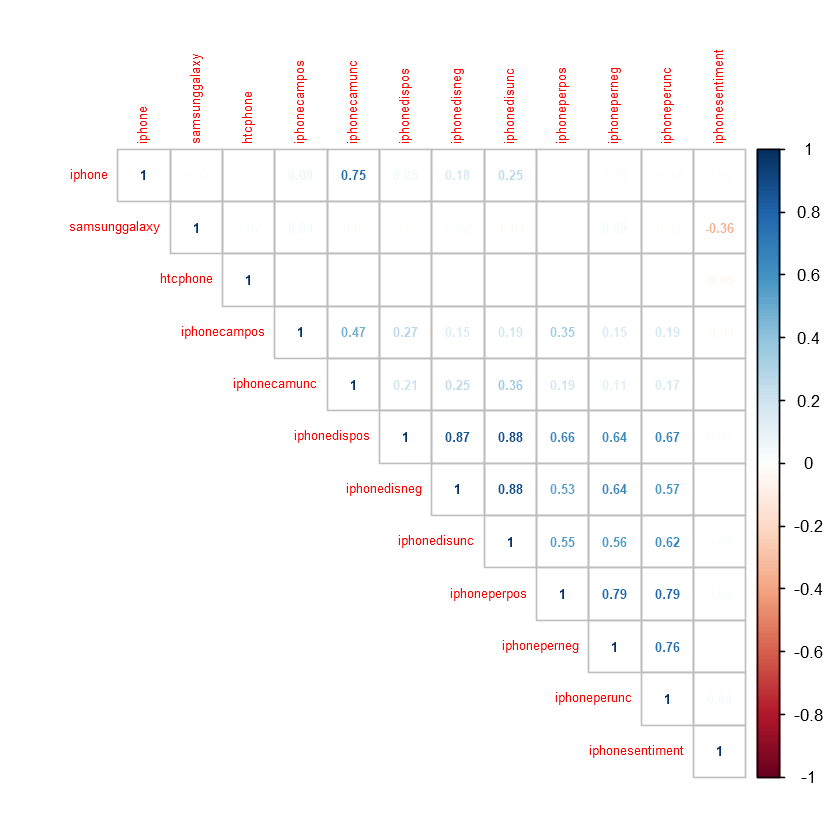

In [10]:
# Checking the correlation coefficient of Data set ####
Iphone_No_NZV.correlation <- cor(Iphone_No_NZV)
Iphone_No_NZV.correlation.plot <- corrplot(Iphone_No_NZV.correlation, 
                                           method = "number", 
                                           type = "upper",
                                           tl.cex = 0.6,   
                                           number.cex = 0.6
                                          )

### Matching the columns of LargeMatrix with SmallMatrix

In [11]:
# Setting Large Matrix as data frame
LargeMatrix <- as.data.frame(LargeMatrix)

In [12]:
# Preprocessing data for matching
Iphone_No_NZV_ForMatch  <- Iphone_No_NZV
Iphone_No_NZV_ForMatch$iphonesentiment <- NULL 

In [13]:
# Matching the columns of LargeMatrix with Small Matrix
LargeMatrix_Iphone_Match <- LargeMatrix[ , match(colnames(Iphone_No_NZV_ForMatch), 
                                                 colnames(LargeMatrix)
                                                )
                                       ]

### Modeling

In [14]:
# Changing Data type
Iphone_No_NZV$iphonesentiment <- as.factor(Iphone_No_NZV$iphonesentiment) 

In [15]:
# Sampling the training data set
set.seed(123)
Iphone_No_NZV_Sample <- Iphone_No_NZV[sample(1:nrow(Iphone_No_NZV), 
                                             nrow(Iphone_No_NZV), 
                                             replace = FALSE
                                            ),
                                     ]

In [16]:
# Splitting Data into Training and Testing Data set
inTraining <- createDataPartition(Iphone_No_NZV_Sample$iphonesentiment, 
                                  p = .7, 
                                  list = FALSE 
                                 )
training <- Iphone_No_NZV_Sample[inTraining, ]
testing <- Iphone_No_NZV_Sample[-inTraining, ]

In [17]:
# fixing the connetion
registerDoSEQ()

In [18]:
# Setting cross validation within training set
fitControl <- trainControl(method = "repeatedcv", 
                           number = 10, 
                           repeats = 1
                          )

In [19]:
# Modeling with RandomForest
rfGrid <- expand.grid(mtry=c(2))
rfFitModel_Iphone <- train(iphonesentiment~.,
                           data = training,
                           method = "rf",
                           trControl = fitControl,
                           tuneGrid = rfGrid
                          )

### Prediction of Iphone sentiment 

In [20]:
# Prediction within SmallMatrix
predictionIphone_SmallMatrix <- predict(rfFitModel_Iphone, testing)

In [21]:
# Changing data types
predictionIphone_SmallMatrix <- as.factor(predictionIphone_SmallMatrix)
testing$iphonesentiment <- as.factor(testing$iphonesentiment)

In [22]:
# Checking the accuracy
postResample(predictionIphone_SmallMatrix, testing$iphonesentiment)

Accuracy     Kappa 
0.7550129 0.5144888

In [23]:
# Prediction with LargeMatrix
PredictionIphone_LargeMatrix <- predict(rfFitModel_Iphone, LargeMatrix_Iphone_Match)

### Visualization

In [25]:
# Creating Matrix to conbined prediction based on LargeMatrix and SmallMatrix
PredictionIphone_LargeMatrix <- as.matrix(PredictionIphone_LargeMatrix)
IphonesentimentSmall <- as.matrix(Iphone_No_NZV$iphonesentiment)

In [26]:
# Combining Matrix 
CombinedIphoneSent <- rbind(PredictionIphone_LargeMatrix, IphonesentimentSmall)

In [27]:
# Changing the data frame for visualization
CombinedIphoneSent <- as.data.frame(CombinedIphoneSent)

In [28]:
# Changing the name of the columns
colnames(CombinedIphoneSent) <- c("Iphonesentiment")

In [29]:
# Drawing a bargraph
BargraphIphoneSent <- ggplot(CombinedIphoneSent, aes(x = Iphonesentiment, binwidth = 5,  
                                                main = "Histogram for Age", 
                                                xlab = "Age",  
                                                fill=I("#00AFBB"), 
                                                col=I("#0072B2")
                                               )
                        ) + geom_bar()

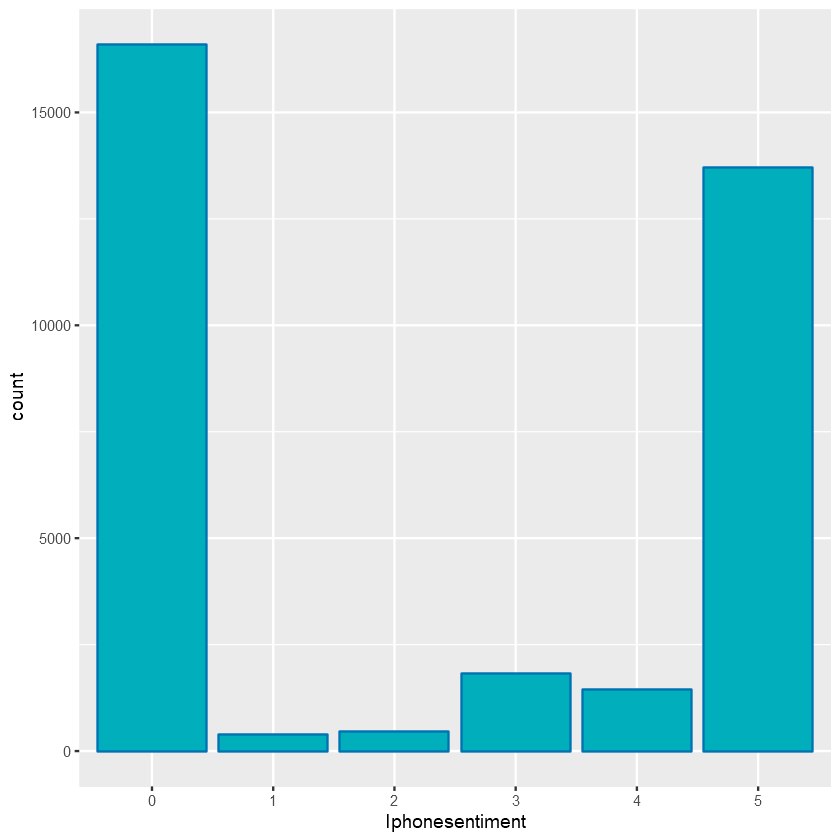

In [30]:
BargraphIphoneSent

## Sentiment Analysis towards Galaxy

In [32]:
# Reading Small Matrix (Train data) for Galaxy ####
RawData_Galaxy <- read.csv("C:/Users/spxt6/OneDrive/Dokumente/R_projects/Test.Proj/AWS/galaxy_smallmatrix_labeled_8d.csv",
                          TRUE,
                          sep =","
                         )
Galaxy_Train <- RawData_Galaxy

In [60]:
head(Galaxy_Train)

iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,galaxysentiment
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [33]:
# Reading Large Matrix (Validation data) for Galaxy ####
RawData_LargeMatrix <- read.csv("C:/Users/spxt6/OneDrive/Dokumente/R_projects/Test.Proj/AWS/LargeMatrix.csv", TRUE, sep =",")
LargeMatrix <- RawData_LargeMatrix

In [61]:
head(LargeMatrix)

id,iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,...,samsungperunc,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc
0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


### Feature Selection

In [34]:
# Setting Galaxy_Train data as data frame
Galaxy_Train.df <- as.data.frame(Galaxy_Train)

In [35]:
# Finding Near Zero Variances
nzv <- nearZeroVar(Galaxy_Train.df, saveMetrics = FALSE)

In [36]:
# Creating a new data set without near zero variance
Galaxy_No_NZV <- Galaxy_Train.df[,-nzv]

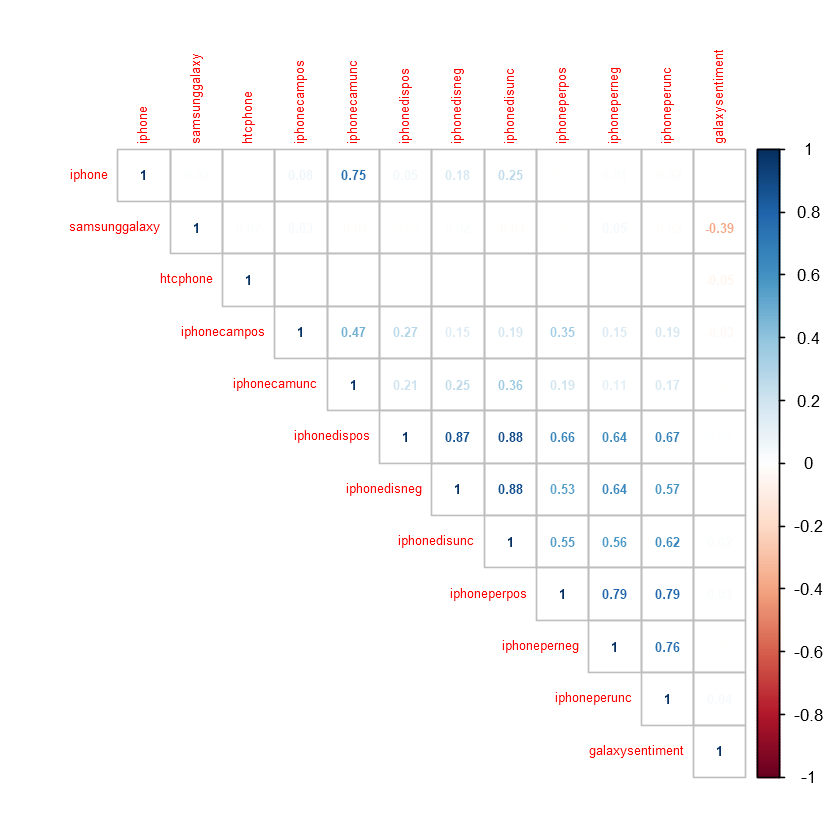

In [37]:
# Checking the correlation coefficient of Data set ####
Galaxy_No_NZV.correlation <- cor(Galaxy_No_NZV)
Galaxy_No_NZV.correlation.plot <- corrplot(Galaxy_No_NZV.correlation, 
                                           method = "number", 
                                           type = "upper",
                                           tl.cex = 0.6,   
                                           number.cex = 0.6
                                          )

### Matching the columns of LargeMatrix with SmallMatrix 

In [38]:
# Setting Large Matrix as data frame
LargeMatrix <- as.data.frame(LargeMatrix)

In [39]:
# Preprocessing data for matching
Galaxy_No_NZV_ForMatch <- Galaxy_No_NZV
Galaxy_No_NZV_ForMatch$galaxysentiment <- NULL

In [40]:
# Matching the columns of LargeMatrix and SmallMatrix
LargeMatrix_Galaxy_Match <- LargeMatrix[ , match(colnames(Galaxy_No_NZV_ForMatch), 
                                                 colnames(LargeMatrix)
                                                )
                                       ]

### Modeling

In [42]:
# Changing Data type
Galaxy_No_NZV$galaxysentiment <- as.factor(Galaxy_No_NZV$galaxysentiment)

In [43]:
# Sampling training data set
set.seed(123)
Galaxy_No_NZV_Sample <- Galaxy_No_NZV[sample(1:nrow(Galaxy_No_NZV), 
                                             nrow(Galaxy_No_NZV),
                                             replace=FALSE
                                            ),
                                     ]

In [44]:
# Splitting Data into Training and Testing Data set
inTraining <- createDataPartition(Galaxy_No_NZV_Sample$galaxysentiment, 
                                  p = .7, 
                                  list = FALSE 
                                 )
training <- Galaxy_No_NZV_Sample[inTraining, ]
testing <- Galaxy_No_NZV_Sample[-inTraining, ]

In [45]:
# fix the connetion
registerDoSEQ()

In [46]:
# Setting cross validation within training set
fitControl <- trainControl(method = "repeatedcv", 
                           number = 10, 
                           repeats = 1
                          )

In [47]:
# Modeling with RandomForest ####
rfGrid <- expand.grid(mtry = c(2))
rfFitModel_Galaxy <- train(galaxysentiment~ .,
                           data = training,
                           method = "rf",
                           trControl = fitControl,
                           tuneGrid = rfGrid
                          )

### Prediction of Galaxy sentiment

In [48]:
# Prediction within SmallMatrix
PredictionGalaxy_SmallMatrix <- predict(rfFitModel_Galaxy, testing)

In [49]:
# Changing data types
PredictionGalaxy_SmallMatrix <- as.factor(PredictionGalaxy_SmallMatrix)
testing$galaxysentiment <- as.factor(testing$galaxysentiment)

In [50]:
# Checking the accuracy
postResample(PredictionGalaxy_SmallMatrix, testing$galaxysentiment)

Accuracy     Kappa 
0.7765492 0.5464319

In [51]:
# Predition with LargeMatrix
PredictionGalaxy_LargeMatrix <- predict(rfFitModel_Galaxy, LargeMatrix_Galaxy_Match)

### Visualization

In [52]:
# Creating Matrix to combine prediction based on LargeMatrix and SmallMatrix
PredictionGalaxy_LargeMatrix <- as.matrix(PredictionGalaxy_LargeMatrix)
GalaxysentimentSmall <- as.matrix(Galaxy_No_NZV$galaxysentiment)

In [53]:
# Combining Matrix
CombinedGalaxySent <- rbind(PredictionGalaxy_LargeMatrix, GalaxysentimentSmall)

In [54]:
# Changing the data frame for Visualization
CombinedGalaxySent <- as.data.frame(CombinedGalaxySent)

In [55]:
# Changing the name of the columns
colnames(CombinedGalaxySent) <- c("Galaxysentiment")

In [56]:
# Drawing a bargraph
bargraphGalaxy <- ggplot(CombinedGalaxySent, aes(x = Galaxysentiment, binwidth = 5,  
                                                      main = "Histogram for Age", 
                                                      xlab = "Age",  
                                                      fill=I("#FFDB6D"), 
                                                      col=I("#C4961A")
                                                 )
                         ) + geom_bar()

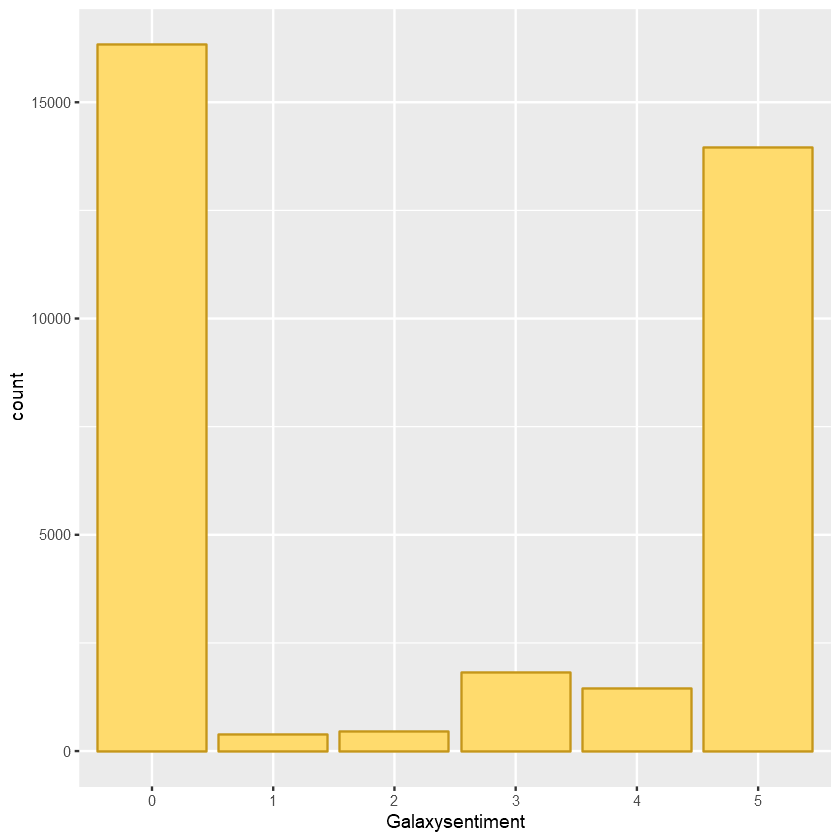

In [57]:
bargraphGalaxy